In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import joblib

df = pd.read_csv('../data/churn.csv')
df.shape


(7043, 21)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])
print(f"\nDataset shape after cleaning: {df.shape}")


Dataset shape after cleaning: (7032, 21)


In [5]:
categorical_features = [col for col in df.columns 
                       if df[col].dtype == 'object' and col != 'customerID' and col != 'Churn']
numerical_features = [col for col in df.columns 
                     if df[col].dtype in ['int64', 'float64'] and col not in ['customerID', 'SeniorCitizen']]
numerical_features.append('SeniorCitizen')  # Include SeniorCitizen

print("\nCategorical features:", categorical_features)
print("Numerical features:", numerical_features)


Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical features: ['tenure', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen']


In [6]:
X = df[categorical_features + numerical_features]
y = df['Churn'].map({'Yes': 1, 'No': 0})  # Numeric labels for all models

In [7]:
print(f"\nTarget distribution:")
print(df['Churn'].value_counts())


Target distribution:
Churn
No     5163
Yes    1869
Name: count, dtype: int64


# 4. Train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Train set size: 5625
Test set size: 1407


# 5. Create preprocessing pipeline

In [9]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

#function to calculate metrics

In [10]:
def calculate_metrics(model, X_test, y_test, model_name):
    """Calculate accuracy, precision, recall, F1, and AUC for a model"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc
    }
    
    print(f"\n{model_name} Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC:       {auc:.4f}")
    
    return metrics

#Random Forest model

In [11]:
print("\nRANDOM FOREST CLASSIFIER")

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))
])
pipeline.fit(X_train, y_train)
rf_metrics = calculate_metrics(pipeline, X_test, y_test, 'Random Forest')


RANDOM FOREST CLASSIFIER

Random Forest Metrics:
  Accuracy:  0.7832
  Precision: 0.6228
  Recall:    0.4679
  F1-Score:  0.5344
  AUC:       0.8173


#logistic_regression

In [12]:
print("\n\nLOGISTIC REGRESSION")

log_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
log_model.fit(X_train, y_train)
log_metrics = calculate_metrics(log_model, X_test, y_test, 'Logistic Regression')



LOGISTIC REGRESSION

Logistic Regression Metrics:
  Accuracy:  0.7257
  Precision: 0.4901
  Recall:    0.7968
  F1-Score:  0.6069
  AUC:       0.8351


#XGboost

In [13]:
print("\n\nXGBOOST")

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', 
                                     scale_pos_weight=scale_pos_weight, random_state=42, verbosity=0))
])
xgb_model.fit(X_train, y_train)
xgb_metrics = calculate_metrics(xgb_model, X_test, y_test, 'XGBoost')



XGBOOST

XGBoost Metrics:
  Accuracy:  0.7434
  Precision: 0.5132
  Recall:    0.6738
  F1-Score:  0.5827
  AUC:       0.8103


#Saving the models pkl

In [14]:
joblib.dump(pipeline, 'churn_model_rf.pkl')
joblib.dump(log_model, 'churn_model_lr.pkl')
joblib.dump(xgb_model, 'churn_model_xgb.pkl')
print("\n\nModels saved:")
print("  - churn_model_rf.pkl")
print("  - churn_model_lr.pkl")
print("  - churn_model_xgb.pkl")



Models saved:
  - churn_model_rf.pkl
  - churn_model_lr.pkl
  - churn_model_xgb.pkl


#MODEL COMPARISON

In [15]:
models_comparison = pd.DataFrame([rf_metrics, log_metrics, xgb_metrics])
models_comparison = models_comparison.round(4)
models_comparison.to_csv('model_comparison.csv', index=False)

print("\n")
print(models_comparison.to_string(index=False))
print("\n\nModel comparison saved as 'model_comparison.csv'")



              Model  Accuracy  Precision  Recall  F1-Score    AUC
      Random Forest    0.7832     0.6228  0.4679    0.5344 0.8173
Logistic Regression    0.7257     0.4901  0.7968    0.6069 0.8351
            XGBoost    0.7434     0.5132  0.6738    0.5827 0.8103


Model comparison saved as 'model_comparison.csv'


#DETAILED EVALUATION - BEST MODEL (LOGISTIC REGRESSION)

In [16]:
print("DETAILED EVALUATION - LOGISTIC REGRESSION (BEST MODEL)")


y_pred = log_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

DETAILED EVALUATION - LOGISTIC REGRESSION (BEST MODEL)

Confusion Matrix:
[[723 310]
 [ 76 298]]

Classification Report:
              precision    recall  f1-score   support

    No Churn       0.90      0.70      0.79      1033
       Churn       0.49      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



#THRESHOLD TUNING ANALYSIS

In [17]:
print("THRESHOLD TUNING ANALYSIS")


y_pred_proba = log_model.predict_proba(X_test)[:, 1]
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

print("\nMetrics at different prediction thresholds:")
print("(Lower threshold = Higher Recall, Lower Precision)\n")

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    
    acc = accuracy_score(y_test, y_pred_threshold)
    prec = precision_score(y_test, y_pred_threshold, zero_division=0)
    rec = recall_score(y_test, y_pred_threshold, zero_division=0)
    f1 = f1_score(y_test, y_pred_threshold, zero_division=0)
    auc_val = roc_auc_score(y_test, y_pred_proba)
    
    threshold_results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'AUC': auc_val
    })
    
    print(f"Threshold {threshold}:")
    print(f"  Accuracy:  {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

threshold_df = pd.DataFrame(threshold_results)
threshold_df.to_csv('threshold_analysis.csv', index=False)
print(f"\nThreshold analysis saved as 'threshold_analysis.csv'")

THRESHOLD TUNING ANALYSIS

Metrics at different prediction thresholds:
(Lower threshold = Higher Recall, Lower Precision)

Threshold 0.3:
  Accuracy:  0.6326 | Precision: 0.4148 | Recall: 0.9305 | F1: 0.5738
Threshold 0.4:
  Accuracy:  0.6851 | Precision: 0.4521 | Recall: 0.8717 | F1: 0.5954
Threshold 0.5:
  Accuracy:  0.7257 | Precision: 0.4901 | Recall: 0.7968 | F1: 0.6069
Threshold 0.6:
  Accuracy:  0.7633 | Precision: 0.5414 | Recall: 0.7166 | F1: 0.6168
Threshold 0.7:
  Accuracy:  0.7939 | Precision: 0.6111 | Recall: 0.6176 | F1: 0.6144

Threshold analysis saved as 'threshold_analysis.csv'


CONFUSION MATRIX AT THRESHOLD = 0.6

Confusion Matrix:
[[806 227]
 [106 268]]

True Negatives (TN): 806
False Positives (FP): 227
False Negatives (FN): 106
True Positives (TP): 268


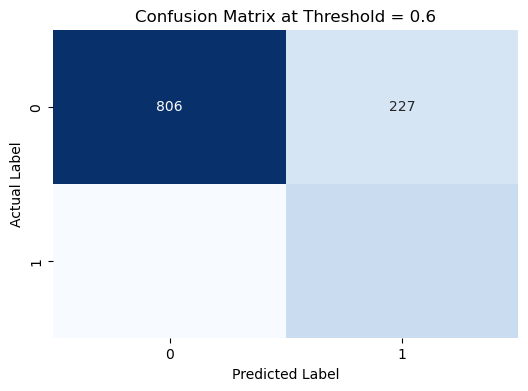


Model Performance at Selected Threshold:
Accuracy:  0.7633
Precision: 0.5414
Recall:    0.7166
F1-score:  0.6168


In [18]:

best_threshold = 0.6

print(f"CONFUSION MATRIX AT THRESHOLD = {best_threshold}")



y_pred_best = (y_pred_proba >= best_threshold).astype(int)

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:")
print(cm)


tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title(f"Confusion Matrix at Threshold = {best_threshold}")
plt.show()


acc = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best)
rec = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print("\nModel Performance at Selected Threshold:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")


In [19]:
print("OPTIMAL THRESHOLD RECOMMENDATION")


optimal_threshold = 0.4
print(f"\nRecommended Threshold: {optimal_threshold}")
print(f"Rationale: Balances recall (catch churners) with precision (minimize false alarms)")

optimal_idx = np.argmin(np.abs(threshold_df['Threshold'] - optimal_threshold))
optimal_metrics = threshold_df.iloc[optimal_idx]

print(f"\nMetrics at threshold {optimal_threshold}:")
print(f"  Accuracy:  {optimal_metrics['Accuracy']:.4f}")
print(f"  Precision: {optimal_metrics['Precision']:.4f}")
print(f"  Recall:    {optimal_metrics['Recall']:.4f}")
print(f"  F1-Score:  {optimal_metrics['F1-Score']:.4f}")

OPTIMAL THRESHOLD RECOMMENDATION

Recommended Threshold: 0.4
Rationale: Balances recall (catch churners) with precision (minimize false alarms)

Metrics at threshold 0.4:
  Accuracy:  0.6851
  Precision: 0.4521
  Recall:    0.8717
  F1-Score:  0.5954


In [20]:
print("DEPLOYING MODEL WITH OPTIMAL THRESHOLD")


def predict_churn_with_threshold(model, X_input, threshold=0.4):
    """Predict churn with custom threshold and risk levels"""
    proba = model.predict_proba(X_input)[:, 1]
    prediction = (proba >= threshold).astype(int)
    
    risk_level = []
    for prob in proba:
        if prob >= 0.7:
            risk_level.append('High Risk')
        elif prob >= threshold:
            risk_level.append('Medium Risk')
        else:
            risk_level.append('Low Risk')
    
    return prediction, proba, risk_level

deployment_info = {
    'model': log_model,
    'threshold': optimal_threshold,
    'metrics': optimal_metrics.to_dict()
}
joblib.dump(deployment_info, 'churn_model_deployed.pkl')
print(f"\nDeployed model saved as 'churn_model_deployed.pkl'")
print(f"Deployment threshold: {optimal_threshold}")

DEPLOYING MODEL WITH OPTIMAL THRESHOLD

Deployed model saved as 'churn_model_deployed.pkl'
Deployment threshold: 0.4


#TEST DEPLOYMENT ON SAMPLE CUSTOMER

In [21]:

sample_customer = pd.DataFrame([{
    'gender': 'Male',
    'SeniorCitizen': 0,
    'Partner': 'No',
    'Dependents': 'No',
    'tenure': 12,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'Fiber optic',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 85.50,
    'TotalCharges': 1026.00
}])

sample_prediction, sample_proba, sample_risk = predict_churn_with_threshold(
    log_model, sample_customer, threshold=optimal_threshold
)

print("DEPLOYMENT TEST - SAMPLE CUSTOMER")

print(f"\nCustomer Profile:")
print(f"  Tenure: 12 months")
print(f"  Internet Service: Fiber optic")
print(f"  Contract: Month-to-month")
print(f"  Monthly Charges: $85.50")
print(f"\nPrediction Results:")
print(f"  Churn Probability: {sample_proba[0]:.4f} ({sample_proba[0]*100:.2f}%)")
print(f"  Risk Level: {sample_risk[0]}")
print(f"  Recommended Action: {'CONTACT IMMEDIATELY' if sample_prediction[0] == 1 else 'Monitor'}")


DEPLOYMENT TEST - SAMPLE CUSTOMER

Customer Profile:
  Tenure: 12 months
  Internet Service: Fiber optic
  Contract: Month-to-month
  Monthly Charges: $85.50

Prediction Results:
  Churn Probability: 0.8819 (88.19%)
  Risk Level: High Risk
  Recommended Action: CONTACT IMMEDIATELY


In [22]:
sample_customer = pd.DataFrame([{
    'gender': 'Male',
    'SeniorCitizen': 1,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 24,
    'PhoneService': 'Yes',
    'MultipleLines': 'No',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'No',
    'DeviceProtection': 'No',
    'TechSupport': 'Yes',
    'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes',
    'Contract': '',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 85.50,
    'TotalCharges': 1026.00
}])

sample_prediction, sample_proba, sample_risk = predict_churn_with_threshold(
    log_model, sample_customer, threshold=optimal_threshold
)

print("DEPLOYMENT TEST - SAMPLE CUSTOMER")

print(f"\nCustomer Profile:")
print(f"  Tenure: {sample_customer.loc[0, 'tenure']} months")
print(f"  Internet Service: {sample_customer.loc[0, 'InternetService']}")
print(f"  Contract: {sample_customer.loc[0, 'Contract'] if sample_customer.loc[0, 'Contract'] else 'Not Provided'}")
print(f"  Monthly Charges: ${sample_customer.loc[0, 'MonthlyCharges']:.2f}")

print(f"\nPrediction Results:")
print(f"  Churn Probability: {sample_proba[0]:.4f} ({sample_proba[0]*100:.2f}%)")
print(f"  Risk Level: {sample_risk[0]}")
print(f"  Recommended Action: {'CONTACT IMMEDIATELY' if sample_prediction[0] == 1 else 'Monitor'}")

DEPLOYMENT TEST - SAMPLE CUSTOMER

Customer Profile:
  Tenure: 24 months
  Internet Service: DSL
  Contract: Not Provided
  Monthly Charges: $85.50

Prediction Results:
  Churn Probability: 0.3401 (34.01%)
  Risk Level: Low Risk
  Recommended Action: Monitor


In [23]:
new_data = X_test.sample(5)
pred, proba, risk = predict_churn_with_threshold(log_model, new_data, threshold=0.6)

results = new_data.copy()
results['Churn Probability'] = proba
results['Predicted Churn'] = pred
results['Risk Level'] = risk

print(results[['Churn Probability', 'Predicted Churn', 'Risk Level']])


      Churn Probability  Predicted Churn Risk Level
3317           0.040492                0   Low Risk
3386           0.124365                0   Low Risk
6939           0.381543                0   Low Risk
1387           0.006277                0   Low Risk
5631           0.716804                1  High Risk


In [24]:
print("\nMODEL DEPLOYMENT DEMO")


# Sample 5 random customers from test data
sample_customers = X_test.sample(5, random_state=42)

# Get predictions using the deployment function
predictions, probabilities, risk_levels = predict_churn_with_threshold(
    log_model, sample_customers, threshold=0.4
)

# Combine into a DataFrame for readability
demo_results = sample_customers.copy()
demo_results['Churn Probability'] = probabilities
demo_results['Predicted Churn'] = predictions
demo_results['Risk Level'] = risk_levels


demo_results['Churn Probability'] = demo_results['Churn Probability'].apply(lambda x: f"{x*100:.1f}%")


print("\n🔹 Predicted Churn Risk for Sample Customers:")
display(demo_results[['Churn Probability', 'Predicted Churn', 'Risk Level']])



MODEL DEPLOYMENT DEMO

🔹 Predicted Churn Risk for Sample Customers:


,Churn Probability,Predicted Churn,Risk Level
6970,87.6%,1,High Risk
6331,8.6%,0,Low Risk
4658,54.8%,1,Medium Risk
3471,6.3%,0,Low Risk
192,0.5%,0,Low Risk
